In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
try:
    import empyrical as emp
except:
    emp = None
import tushare as ts
import time
import random

from common.log import *
from common.config import Config
from spider.spider_nasdaq import Spider_nasdaq
from spider.spider_coinmarketcap import Spider_coinmarketcap

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from pandas_highcharts.core import serialize
from pandas_highcharts.display import display_charts

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

CONF = Config('../conf/secret.yaml').data[0]
ts_token = CONF['TUSHARE']['TOKEN']
ts.set_token(ts_token)
pro = ts.pro_api()

CONF = Config().data[0]
MONGODB = CONF['MONGODB']
NASDAQ = CONF['NASDAQ']
CRYPTOCURRENCY = CONF['CRYPTOCURRENCY']
CRYPTOCURRENCY = list(CRYPTOCURRENCY.keys())
NASDAQ100 = CONF['NASDAQ100']

# MONITOR_TARGET = {
#     '399300': {'MA': [30, 150], 'ROLLINGMAX': [100], 'ROLLINGMIN': [40], 'NAME': '沪深300(SZ:399300)'},
#     '000905': {'MA': [90, 120], 'ROLLINGMAX': [30], 'ROLLINGMIN': [20], 'NAME': '中证500(SH:000905)'},
#     '399006': {'MA': [110, 180], 'ROLLINGMAX': [150], 'ROLLINGMIN': [50], 'NAME': '创业板指(SZ:399006)'},
#     'BITCOIN': {'MA': [], 'ROLLINGMAX': [20], 'ROLLINGMIN': [10], 'NAME': 'BITCOIN'},
#     'EOS': {'MA': [], 'ROLLINGMAX': [20], 'ROLLINGMIN': [10], 'NAME': 'EOS'},
# }

MONITOR_TARGET = {
    '399300': {'MA': [17], 'ROLLINGMAX': [100], 'ROLLINGMIN': [40], 'N': 10, 'NAME': '沪深300(SZ:399300)'},
    '000905': {'MA': [17], 'ROLLINGMAX': [30], 'ROLLINGMIN': [20], 'N': 10, 'NAME': '中证500(SH:000905)'},
    '399006': {'MA': [17], 'ROLLINGMAX': [150], 'ROLLINGMIN': [50], 'N': 10, 'NAME': '创业板指(SZ:399006)'},
    'BITCOIN': {'MA': [5], 'ROLLINGMAX': [20], 'ROLLINGMIN': [10], 'N': 2, 'NAME': 'BITCOIN'},
    'EOS': {'MA': [5], 'ROLLINGMAX': [20], 'ROLLINGMIN': [10], 'N': 2, 'NAME': 'EOS'},
    'ETHEREUM': {'MA': [5], 'ROLLINGMAX': [20], 'ROLLINGMIN': [10], 'N': 2, 'NAME': 'ETHEREUM'},
    'RIPPLE': {'MA': [5], 'ROLLINGMAX': [20], 'ROLLINGMIN': [10], 'N': 2, 'NAME': 'RIPPLE'},
    'LITECOIN': {'MA': [5], 'ROLLINGMAX': [20], 'ROLLINGMIN': [10], 'N': 2, 'NAME': 'LITECOIN'},
}

pd

<module 'pandas' from 'd:\\python36\\lib\\site-packages\\pandas\\__init__.py'>

In [2]:
%%time

IS_DOWNLOAD_DATA = True

spider_n = Spider_nasdaq()
spider_c = Spider_coinmarketcap()

for symbol in MONITOR_TARGET:
    if not IS_DOWNLOAD_DATA:
        break
        
    print(symbol)

    # 指数
    if symbol in ['399300', '000905', '000016', '399006']:
        df = ts.get_k_data(code=symbol, index=True, start='2005-01-01', end=time.strftime('%Y-%m-%d'))
        datafile = '../database/market/%s.csv' % symbol
        df.to_csv(datafile, index=False, encoding='utf-8')
        
    # CRYPTOCURRENCY
    elif symbol in CRYPTOCURRENCY:
        datafile = spider_c.get_coin_data(symbol, start_date='20100101', end_date=time.strftime('%Y%m%d'))
        
    # ETF
    else:
        df = ts.get_k_data(code=symbol, ktype='D', autype='qfq', index=False, start='2005-01-01', end=time.strftime('%Y-%m-%d'))
        datafile = '../database/market/%s.csv' % symbol
        df.to_csv(datafile, index=False, encoding='utf-8')
        time.sleep(1)

    time.sleep(1)

399300
000905
399006
BITCOIN
EOS
ETHEREUM
RIPPLE
LITECOIN
Wall time: 23 s


In [3]:
%%time

stock_df_dict = {}

for symbol in MONITOR_TARGET:
    stock_data_file = '../database/market/%s.csv' % symbol
    try:
        stock_df = pd.read_csv(stock_data_file)
    except:
        print(symbol)
        continue

    # 筛选字段
#     stock_df = stock_df.loc[:, ['date', 'open', 'close']]
    stock_df = stock_df.loc[:, ['date', 'close']]

    # 去掉Nasdaq行情首行的当天行情
    if symbol in NASDAQ100:
        stock_df = stock_df.drop([0])

    # 抛弃空值异常值
    stock_df.dropna(axis=0, how='any', inplace=True)

    # 格式化日期
    # 445 ms ± 17.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    stock_df = stock_df.assign(date=pd.to_datetime(stock_df['date']))  # need .index.to_period('D')

    # 用日期作索引，日期升序排序
    # 95.1 µs ± 1.58 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
    if symbol in NASDAQ100 or symbol in CRYPTOCURRENCY:
        stock_df = stock_df[::-1]
    stock_df.set_index(['date'], inplace=True)
    stock_df.index = stock_df.index.to_period('D')

    # 计算每天涨跌幅
    N = MONITOR_TARGET[symbol]['N']
    stock_df['N_sht'] = stock_df.close.shift(N)
    stock_df['N_chg'] = (stock_df.close.shift(1) - stock_df.close.shift(N)) / stock_df.close.shift(N)

    for MA_PARAM in MONITOR_TARGET[symbol]['MA']:
        stock_df['MA_%d' % MA_PARAM] = stock_df['close'].rolling(MA_PARAM).mean()
    
    for ROLLINGMAX_PARAM in MONITOR_TARGET[symbol]['ROLLINGMAX']:
        stock_df['ROLLINGMAX_%d' % ROLLINGMAX_PARAM] = stock_df['close'].rolling(ROLLINGMAX_PARAM).max()
        
    for ROLLINGMIN_PARAM in MONITOR_TARGET[symbol]['ROLLINGMIN']:
        stock_df['ROLLINGMIN_%d' % ROLLINGMIN_PARAM] = stock_df['close'].rolling(ROLLINGMIN_PARAM).min()
    
    # 减少数据
    # stock_df = stock_df['2016-01-01':]
    stock_df.dropna(how='any', inplace=True)
    
    stock_df_dict[symbol] = stock_df

Wall time: 1.03 s


In [4]:
%store MONITOR_TARGET
%store stock_df_dict

Stored 'MONITOR_TARGET' (dict)
Stored 'stock_df_dict' (dict)


In [5]:
for symbol in MONITOR_TARGET:
    symbol
    stock_df_dict[symbol].tail(5)

'399300'

,close,N_sht,N_chg,MA_17,ROLLINGMAX_100,ROLLINGMIN_40
date,,,,,,
2019-05-27,3637.20,3668.73,-0.020394,3676.401176,4120.61,3583.96
2019-05-28,3672.26,3645.15,-0.002181,3662.227647,4120.61,3583.96
2019-05-29,3663.91,3727.09,-0.014711,3661.009412,4120.61,3583.96
2019-05-30,3641.18,3743.96,-0.021381,3656.333529,4120.61,3583.96
2019-05-31,3629.79,3648.76,-0.002077,3654.117647,4120.61,3583.96


'000905'

,close,N_sht,N_chg,MA_17,ROLLINGMAX_30,ROLLINGMIN_20
date,,,,,,
2019-05-27,4962.95,5005.90,-0.032789,4986.864118,5810.18,4841.76
2019-05-28,4955.49,4965.61,-0.000536,4966.154118,5810.18,4841.76
2019-05-29,4956.86,5076.56,-0.023849,4968.981176,5810.18,4841.76
2019-05-30,4926.40,5108.36,-0.029657,4966.216471,5810.18,4841.76
2019-05-31,4912.00,4942.58,-0.003274,4964.114118,5810.18,4841.76


'399006'

,close,N_sht,N_chg,MA_17,ROLLINGMAX_150,ROLLINGMIN_50
date,,,,,,
2019-05-27,1491.95,1503.06,-0.039460,1499.142353,1777.26,1443.75
2019-05-28,1505.16,1494.60,-0.001773,1492.164706,1777.26,1443.75
2019-05-29,1497.89,1528.69,-0.015392,1492.341176,1777.26,1443.75
2019-05-30,1485.24,1533.67,-0.023330,1491.228235,1777.26,1443.75
2019-05-31,1483.66,1478.75,0.004389,1491.333529,1777.26,1443.75


'BITCOIN'

,close,N_sht,N_chg,MA_5,ROLLINGMAX_20,ROLLINGMIN_10
date,,,,,,
2019-05-28,8719.96,8673.22,0.015284,8447.774,8805.78,7680.07
2019-05-29,8659.49,8805.78,-0.009746,8582.198,8805.78,7680.07
2019-05-30,8319.47,8719.96,-0.006935,8635.584,8805.78,7680.07
2019-05-31,8574.50,8659.49,-0.039266,8615.840,8805.78,7680.07
2019-06-01,8564.02,8319.47,0.030655,8567.488,8805.78,7881.85


'EOS'

,close,N_sht,N_chg,MA_5,ROLLINGMAX_20,ROLLINGMIN_10
date,,,,,,
2019-05-28,8.05,6.91,0.154848,7.146,8.05,5.97
2019-05-29,7.98,7.98,0.008772,7.462,8.05,5.97
2019-05-30,7.37,8.05,-0.008696,7.658,8.05,5.97
2019-05-31,8.51,7.98,-0.076441,7.978,8.51,5.97
2019-06-01,7.78,7.37,0.154681,7.938,8.51,6.05


'ETHEREUM'

,close,N_sht,N_chg,MA_5,ROLLINGMAX_20,ROLLINGMIN_10
date,,,,,,
2019-05-28,271.77,267.07,0.021680,262.588,272.86,244.70
2019-05-29,269.46,272.86,-0.003995,266.584,272.86,244.70
2019-05-30,255.86,271.77,-0.008500,267.404,272.86,244.70
2019-05-31,268.11,269.46,-0.050471,267.612,272.86,244.70
2019-06-01,265.39,255.86,0.047878,266.118,272.86,245.97


'RIPPLE'

,close,N_sht,N_chg,MA_5,ROLLINGMAX_20,ROLLINGMIN_10
date,,,,,,
2019-05-28,0.446549,0.408413,0.063061,0.412142,0.456005,0.376637
2019-05-29,0.443713,0.434168,0.028517,0.423977,0.456005,0.376637
2019-05-30,0.422395,0.446549,-0.006351,0.431048,0.456005,0.376637
2019-05-31,0.438574,0.443713,-0.048045,0.437080,0.456005,0.376637
2019-06-01,0.430583,0.422395,0.038303,0.436363,0.456005,0.381204


'LITECOIN'

,close,N_sht,N_chg,MA_5,ROLLINGMAX_20,ROLLINGMIN_10
date,,,,,,
2019-05-28,114.93,111.42,0.059325,109.390,118.03,88.21
2019-05-29,115.08,118.03,-0.026265,112.426,118.03,88.21
2019-05-30,108.80,114.93,0.001305,113.652,118.03,88.21
2019-05-31,114.54,115.08,-0.054571,114.276,118.03,88.21
2019-06-01,112.62,108.80,0.052757,113.194,118.03,89.18


,SYMBOL,DATE,NOW,BUY,BUYDIFF,SELL,SELLDIFF,MA,MADIFF,N_chg,N_sht
0,399300,2019-05-31,3629.790000,4120.610000,+13.52%,3583.960000,-1.26%,3654.117647,-0.67%,-0.21%,3648.760000
1,000905,2019-05-31,4912.000000,5810.180000,+18.29%,4841.760000,-1.43%,4964.114118,-1.06%,-0.33%,4942.580000
2,399006,2019-05-31,1483.660000,1777.260000,+19.79%,1443.750000,-2.69%,1491.333529,-0.52%,0.44%,1478.750000
3,BITCOIN,2019-06-01,8564.020000,8805.780000,+2.82%,7881.850000,-7.97%,8567.488000,-0.04%,3.07%,8319.470000
4,EOS,2019-06-01,7.780000,8.510000,+9.38%,6.050000,-22.24%,7.938000,-2.03%,15.47%,7.370000
5,ETHEREUM,2019-06-01,265.390000,272.860000,+2.81%,245.970000,-7.32%,266.118000,-0.27%,4.79%,255.860000
6,RIPPLE,2019-06-01,0.430583,0.456005,+5.90%,0.381204,-11.47%,0.436363,-1.34%,3.83%,0.422395
7,LITECOIN,2019-06-01,112.620000,118.030000,+4.80%,89.180000,-20.81%,113.194000,-0.51%,5.28%,108.800000


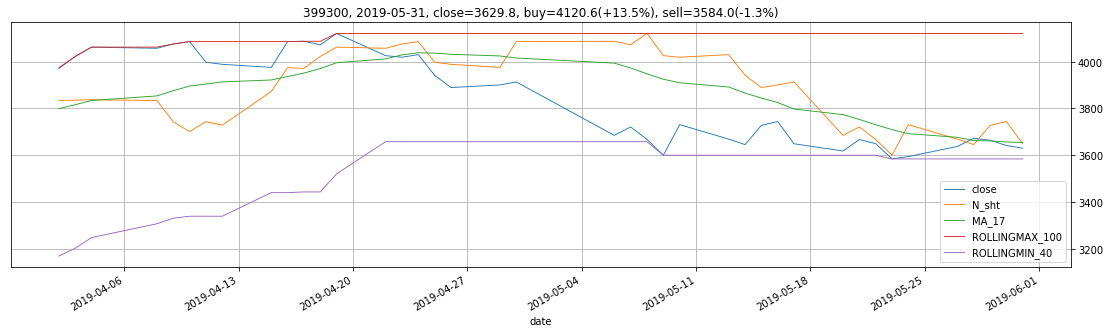

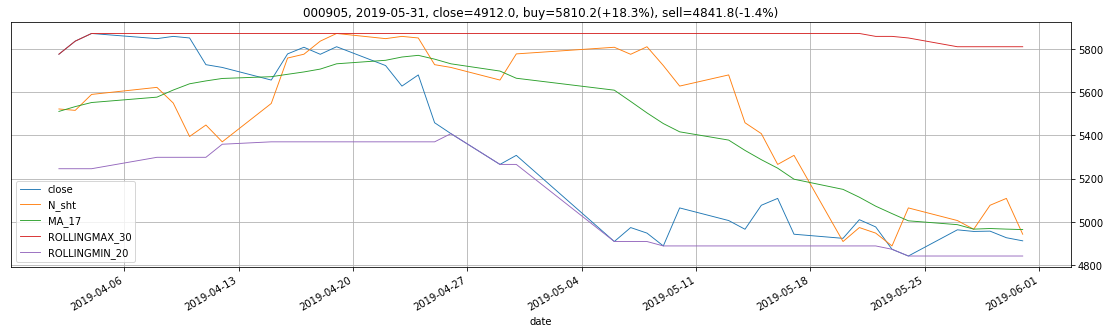

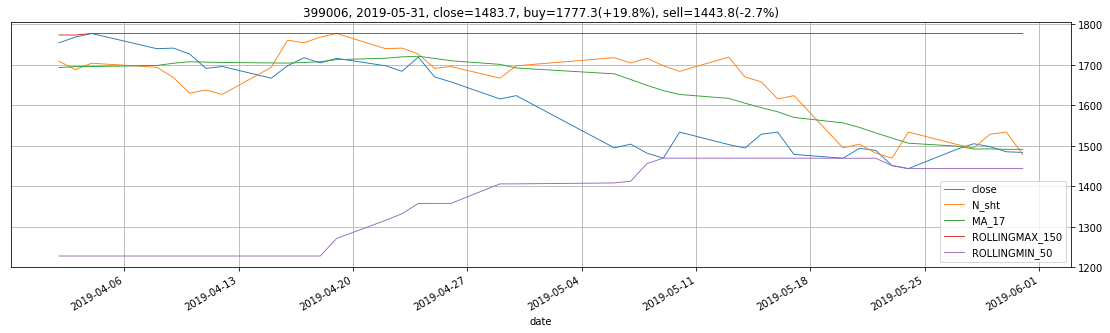

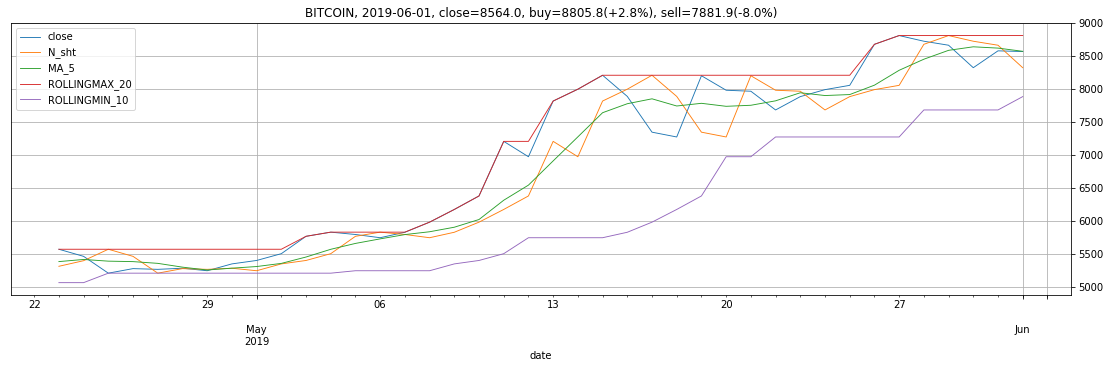

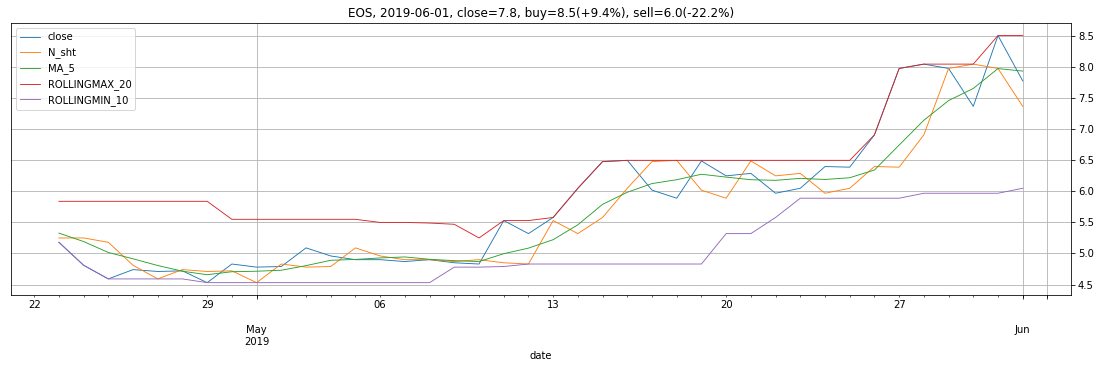

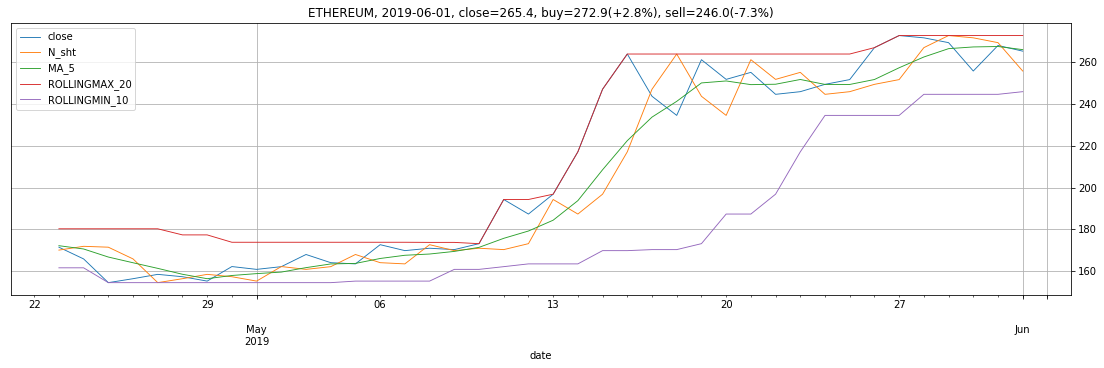

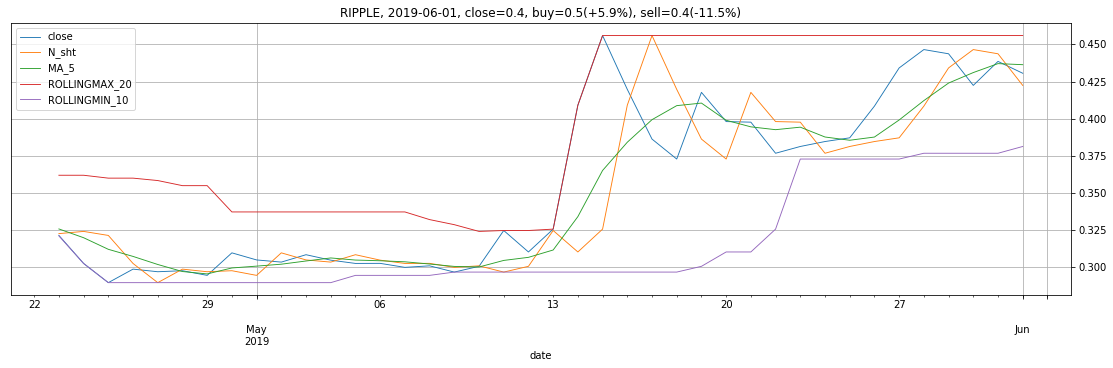

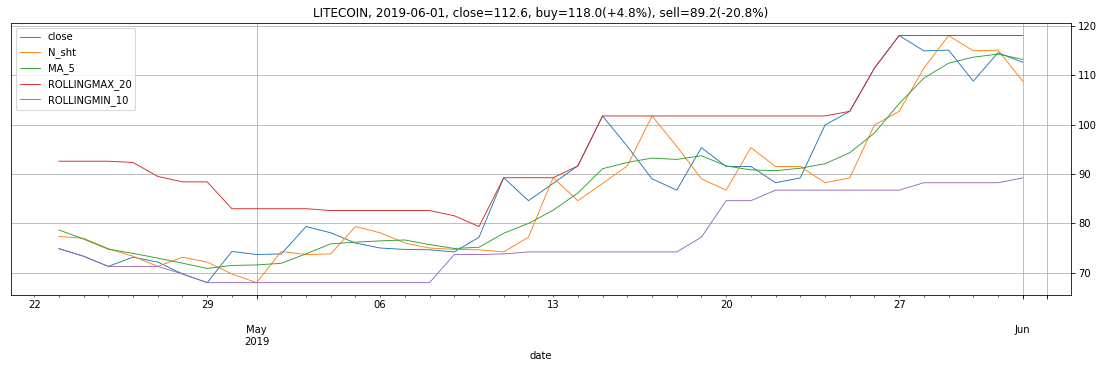

In [6]:
monitor_df = pd.DataFrame(columns=['SYMBOL', 'DATE', 'NOW', 'BUY', 'BUYDIFF', 'SELL', 'SELLDIFF'])

for symbol in MONITOR_TARGET:
    df = stock_df_dict[symbol].iloc[-40:].copy()
    
    df.reset_index(drop=False, inplace=True)
    # df = df.astype(dtype={'date': 'datetime64[ns]'})
    df['date'] = df['date'].apply(lambda x: x.to_timestamp().to_datetime64())
    df.set_index('date', inplace=True)
    
    today_market = df.iloc[-1]
    now_point = today_market.close
    for col in df.columns:
        if 'ROLLINGMAX' in col:
            buy_point = today_market[col]
            buy_diff = (buy_point - now_point) / now_point * 100
        elif 'ROLLINGMIN' in col:
            sell_point = today_market[col]
            sell_diff = (now_point - sell_point) / now_point * 100
        elif 'MA' in col:
            ma = today_market[col]
            ma_diff = (now_point - ma) / now_point * 100
        elif 'N_chg' in col:
            n_chg = today_market[col] * 100
    
    monitor_df = monitor_df.append({
        'SYMBOL': symbol, 
        'DATE': today_market.name.date(), 
        'NOW': now_point, 
        'BUY': buy_point, 
        'BUYDIFF': '+%.2f%%' % buy_diff, 
        'SELL': sell_point, 
        'SELLDIFF': '-%.2f%%' % sell_diff,
        'MA': ma,
        'MADIFF': '%.2f%%' % ma_diff,
        'N_sht': today_market.N_sht, 
        'N_chg': '%.2f%%' % n_chg,
    }, ignore_index=True)
    
    title = '%s, %s, close=%.1f, buy=%.1f(+%.1f%%), sell=%.1f(-%.1f%%)' % \
        (symbol, today_market.name.date(), now_point, buy_point, buy_diff, sell_point, sell_diff)
    
    df.drop(columns=['N_chg'], inplace=True)
    ax = df.plot(kind='line', title=title, linewidth=0.9, grid=True, figsize=(19, 5))
    ax.yaxis.tick_right()
    
#     display_charts(df, chart_type='stock', kind='line', title=title, figsize=(1000, 600))


monitor_df

In [7]:
# df = ts.get_realtime_quotes(['sh', 'sz', 'hs300', 'sz50', 'sh000905', 'zxb', 'cyb'])
df = ts.get_realtime_quotes(['hs300', 'sh000905', 'cyb'])
# df = ts.get_realtime_quotes(list(MONITOR_TARGET.keys()))
df
# list(MONITOR_TARGET.keys())

,name,open,pre_close,price,high,low,bid,ask,volume,amount,...,a2_p,a3_v,a3_p,a4_v,a4_p,a5_v,a5_p,date,time,code
0,沪深300,3640.9963,3641.1833,3629.7893,3668.1796,3627.5448,0,0,89222267,108264201339,...,0,,0,,0,,0,2019-05-31,15:01:56,000300
1,中证500,4923.9199,4926.4030,4912.0005,4969.0513,4902.7379,0,0,86716729,75731116074,...,0,,0,,0,,0,2019-05-31,15:01:56,000905
2,创业板指,1487.276,1485.242,1483.658,1498.244,1474.525,0.000,0.000,6546527860,77733464805.940,...,0.000,,0.000,,0.000,,0.000,2019-05-31,15:00:03,399006
